In [ ]:
from torch_erg import load_pglib_opf as lp
from torch_erg.utils import laplacian_matrix
from torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

: 

In [2]:
# test grid of reference, can either be 30_ieee, 118_ieee or 300_ieee
name = '30_ieee'

# soft connectivity constraint flag, if false then hard constraint is used
# take one of the examples from the repo
SOFT_CONN = True

ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)
ordlist = torch.tensor(ordlist)
buslist = torch.tensor(buslist)
countlist = torch.tensor(countlist)


#convert the matrix to a sparse format
G_sparse = ordmat.cpu().numpy()  
n_components = connected_components(csr_matrix(G_sparse))
print("Number of connected components in the graph:", n_components[0])




Number of connected components in the graph: 1


In [3]:
#define your sampler obj with your observables

class MySampler(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)
    def observables(self,mtx):
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        return(torch.stack([edges, triangles,ac]))

In [4]:
#parameters to touch if you want to affect convergence
alpha = 0.002
niter = 100000
min_change = 0.01
update_steps = 3

sampler = MySampler(backend="cuda")
#starting point of parameters
betas = torch.tensor([0., 0., 0.], dtype=float)
obs = sampler.observables(ordmat)

# run with parameter estimation
parlist = sampler.param_run(graph=ordmat,
                      observables=obs,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change = min_change)



CUDA backend not available falling back to cpu


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3628.94it/s]

number of accepted steps is:  25090
number of rejected samples:  74910
number of effective updates is:  8363


[-2.26564393  0.03248416  0.04251697]
(2034, 3)


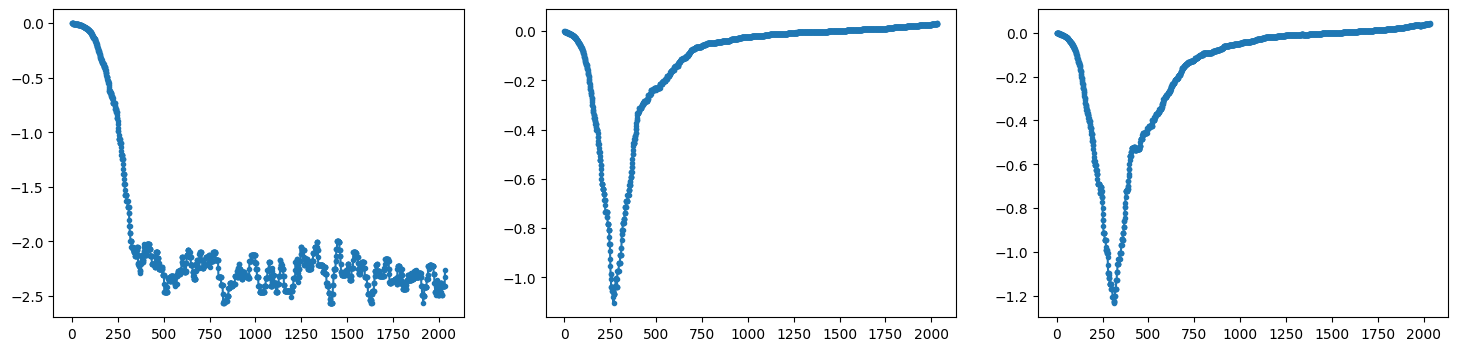

In [5]:
params = [p.cpu().numpy() for p in parlist[0]]
parlist_np = np.array(params)
print(parlist_np[-1])
print(parlist_np.shape)

w = 10
h = 8
scale = 0.6

w = int(w * scale)
h = int(h * scale)

plt.figure(figsize = (parlist_np.shape[1] * w, h))
for p in range(parlist_np.shape[1]):
    plt.subplot(1,parlist_np.shape[1], p + 1)
    plt.plot(parlist_np[:,p], '.-')

In [8]:
params_for_estimates = torch.stack(parlist[0][:-100:-1]).mean(axis = 0)
# run in sample mode, without parameter modifications
graphs, observables = sampler.sample_run(graph=ordmat,
                      observables=obs,
                      params=params_for_estimates,
                      niter=niter,
                      save_every=50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:25<00:00, 3903.41it/s]

number of accepted steps is:  17517
number of rejected samples:  82483
Mean obs:  tensor([3.8083e+01, 3.0088e+00, 3.3722e-02], dtype=torch.float64)


In [9]:
obs

tensor([41.0000,  6.0000,  0.2121], dtype=torch.float64)